# Udacity Self-Driving Car ND:  Vehicle Detection Project
This note book contains the code required for implementing pipeline for vehicle detection.

##  1. Histogram of Oriented Gradients (HOG)
The implementation for camera calibrartion using calibration images of chess boards.

### 1.1 Python Module imports needed 
Import the needed Python modules.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
import pickle

#Global Variables
modelname = './trained-model.pkl'


### 1.2 Read in the training dataset
Import the needed Python modules.

In [ ]:
# Read in cars and notcars
car_img_list = glob.glob('./vehicles/*/*.png')
print("number of car images: ", len(car_img_list))

noncar_img_list = glob.glob('./non-vehicles/*/*.png')
print("number of non-car images: ", len(noncar_img_list))


### 1.3 Visualize the sample data set

In [ ]:
fig, ax = plt.subplots(6,6, figsize=(25, 25))
fig.subplots_adjust(hspace = 0.25, wspace=0.1)
ax = ax.ravel()

# Step through the list and search for chessboard corners

for i in np.arange(18):
    index = np.random.randint(0,len(car_img_list))
    img = cv2.imread(car_img_list[index])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('A car', fontsize=15)
    ax[i].imshow(img)


for i in np.arange(18, 36):
    index = np.random.randint(0,len(noncar_img_list))
    img = cv2.imread(noncar_img_list[index])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Not a car', fontsize=15)
    ax[i].imshow(img)

### 1.4  Visualize HOG Features

In [ ]:
#read an image from car list and an image noncar list
#visualize the image and the corresponding features
n_orient = 12
n_pix_cell = 8
n_cell_blk = 2
hog_channel = 1

a_car_file = car_img_list[np.random.randint(0,len(car_img_list))]
print(a_car_file)
a_noncar_file = noncar_img_list[np.random.randint(0,len(noncar_img_list))]

# Read in each one by one
car_img = mpimg.imread(a_car_file)
print(car_img.shape)
noncar_img = mpimg.imread(a_noncar_file)

car_features, car_hog_img = get_hog_features(car_img[:,:, hog_channel], n_orient, n_pix_cell, n_cell_blk, vis=True, feature_vec=True)
noncar_features, noncar_hog_img = get_hog_features(noncar_img[:,:, hog_channel], n_orient, n_pix_cell, n_cell_blk, 
                                                   vis=True, feature_vec=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(25, 25))
fig.subplots_adjust(hspace = 0.25, wspace=0.1)

ax1.axis('off')
ax1.set_title('car', fontsize=15)
ax1.imshow(car_img)

ax2.axis('off')
ax2.set_title('car HOG image', fontsize=15)
ax2.imshow(car_hog_img, cmap='gray')

ax3.axis('off')
ax3.set_title('noncar', fontsize=15)
ax3.imshow(noncar_img)

ax4.axis('off')
ax4.set_title('noncar HOG image', fontsize=15)
ax4.imshow(noncar_hog_img, cmap='gray')

In [ ]:
#compare the HOG features with various color spaces
#experiment with the following parameters

cspace = 'YCrCb'
sp_size = 32
h_bins = 32
n_orient = 12
pp_cell = 8
cp_blk = 2
hog_chn = "ALL"  #0,1,2 or "ALL"
spatial_fea = True
hist_fea = True
hog_fea = True

start_time = time.time()
car_features = extract_features(car_img_list, color_space= cspace, spatial_size= (sp_size, sp_size),
                     hist_bins=h_bins, orient=n_orient,
                     pix_per_cell=pp_cell, cell_per_block=cp_blk, hog_channel=hog_chn,
                     spatial_feat=spatial_fea, hist_feat=hist_fea, hog_feat=hog_fea)

noncar_features = extract_features(noncar_img_list, color_space= cspace, spatial_size=(sp_size, sp_size),
                     hist_bins=h_bins, orient=n_orient,
                     pix_per_cell=pp_cell, cell_per_block=cp_blk, hog_channel=hog_chn,
                     spatial_feat=spatial_fea, hist_feat=hist_fea, hog_feat=hog_fea)

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

elapsed_time = time.time() - start_time
print("elapsed_time: {:.3f}".format(elapsed_time))

print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape)

In [ ]:
# Fit a per-column scaler only on the training data
print('Using spatial binning of:',sp_size,
    'and', h_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

t=time.time()

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC, svc = ', round(svc.score(X_test, y_test), 4))

In [ ]:
#Store the model and parameters
def save_model (fname, clf, scaler, color_space, spatial_size, hist_bins, orient,
                     pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):

    #open a file
    fh = open (fname, 'wb')
    
    #instantiate a dictionary to store the model and parameter information
    model_dict = dict()

    model_dict["svc"] = clf
    model_dict["scaler"] = scaler
    model_dict["orient"] = orient
    model_dict["color_space"] = color_space
    model_dict["spatial_size"] = spatial_size
    model_dict["hist_bins"] = hist_bins
    model_dict["pix_per_cell"] = pix_per_cell
    model_dict["cell_per_block"] = cell_per_block
    model_dict["hog_channel"] = hog_channel
    model_dict["spatial_feat"] = spatial_feat
    model_dict["hist_feat"] = hist_feat
    model_dict["hog_feat"] = hog_feat
    
    pickle.dump(model_dict, fh)
    fh.close()

save_model(modelname, svc, X_scaler, cspace, sp_size, h_bins, n_orient, pp_cell, cp_blk, hog_chn,
           spatial_fea, hist_fea, hog_fea)


## 2. Detection 
The following section shall be self contained.

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
from lesson_functions import *
modelname ="./trained-model.pkl"

In [9]:
# load a pe-trained svc model from a serialized (pickle) file
def load_model (fname):
    fh = open(modelname, "rb")
    model_dict = pickle.load(fh)
    fh.close()

    return (model_dict["svc"], model_dict["scaler"], model_dict["orient"], model_dict["color_space"], model_dict["spatial_size"], model_dict["hist_bins"], model_dict["pix_per_cell"], model_dict["cell_per_block"],model_dict["hog_channel"], model_dict["spatial_feat"], model_dict["hist_feat"], model_dict["hog_feat"])

(clf, scaler, orient, color_space, spatial_size, hist_bins, pix_per_cell, 
cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat) = load_model(modelname)
print(orient, color_space, spatial_size, hist_bins, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)


12 YCrCb 32 32 8 2 ALL True True True


## 2. Finding Vehicles
The following function forms a building block to locate vehicles in an image.

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    
   # print("single image: color space {}, space {}, h bins {}, orient {}, pix {}, cpb {}, chn {}, sp {}, hist {}, hg {}".format
   #                  (color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, 
   #                  hist_feat, hog_feat))
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print("features shape: ", features.shape)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print("test features shape: ", features.shape)
 
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            #print("prediction: ", prediction)
    #8) Return windows for positive detections
    return on_windows

image shape:  (64, 64, 3)
(64, 64, 3)
prediction:  [1.]


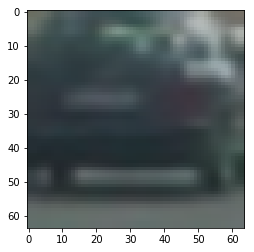

In [11]:
image = mpimg.imread('vehicles/GTI_Far/image0039.png')
draw_image = np.copy(image)
print("image shape: ", image.shape)
#print(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

#image = draw_image.astype(np.float32)/255
#print(image)
test_img = cv2.resize(image, (64, 64))      
print(image.shape)
#4) Extract features for that window using single_img_featuresYCrCb')
features = single_img_features(test_img, color_space='YCrCb', 
                            spatial_size=(32, 32), hist_bins=32, 
                            orient=12, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)
#print(features)
#print("features shape: ", features.shape)
#5) Scale extracted features to be fed to classifier
test_features = scaler.transform(np.array(features).reshape(1, -1))

#print("test features shape: ", features.shape)
 
#6) Predict using your classifier
prediction = clf.predict(test_features)
print("prediction: ", prediction)
plt.imshow(image)

In [14]:
#utility function to plot an image, either gray or color (RGB)
def plot_image (img):
    shape = img.shape
    print(shape)
    if (len(shape) < 3):
        plt.imshow(img, cmap = 'gray')
    else:
        plt.imshow(img)
    plt.show()
    
# #utility function to plot two images, either gray or color (RGB)
def plot2imgs (image1, title1, image2, title2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    if (len(image1.shape) < 3):
        ax1.imshow(image1, cmap='gray')
    else:
        ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)


    if (len(image2.shape) < 3):
        ax2.imshow(image2, cmap='gray')
    else:
        ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
# #utility function to plot two images, either gray or color (RGB)
def plot_img_heat (image1, title1, image2, title2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)

    ax2.imshow(image2, cmap='hot')
    ax2.set_title(title2, fontsize=50)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

18
image name: ./expanded_vehicles\test10.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


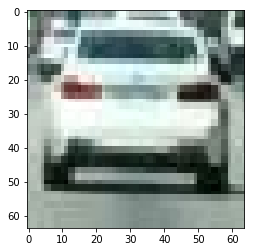

image name: ./expanded_vehicles\test10f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


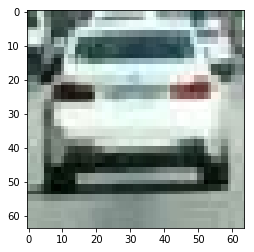

image name: ./expanded_vehicles\test11.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


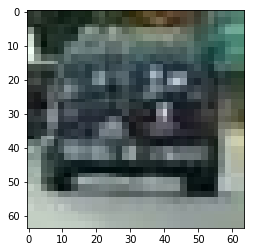

image name: ./expanded_vehicles\test11f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


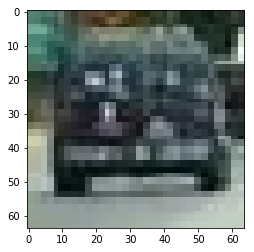

image name: ./expanded_vehicles\test12.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


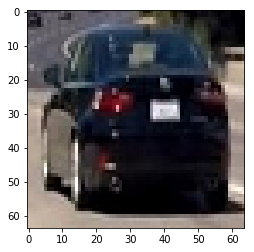

image name: ./expanded_vehicles\test12f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


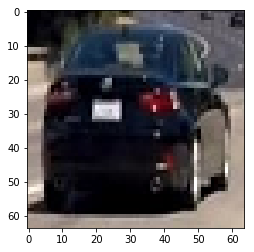

image name: ./expanded_vehicles\test13.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


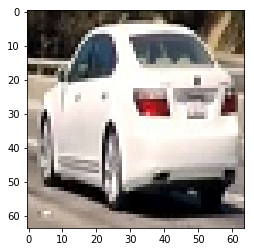

image name: ./expanded_vehicles\test13f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


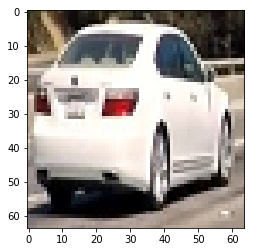

image name: ./expanded_vehicles\test14.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


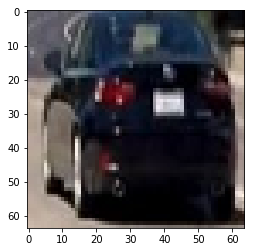

image name: ./expanded_vehicles\test14f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


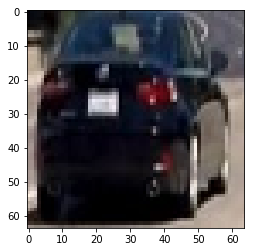

image name: ./expanded_vehicles\test15.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


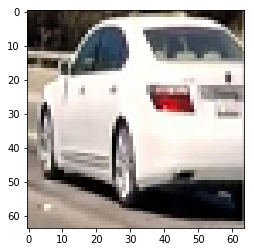

image name: ./expanded_vehicles\test15f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


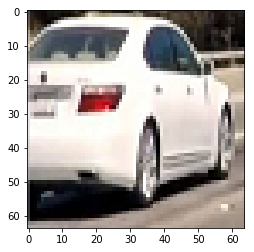

image name: ./expanded_vehicles\test7.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


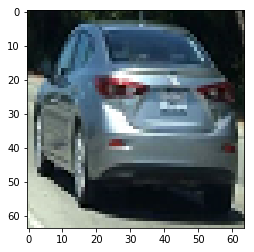

image name: ./expanded_vehicles\test7f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


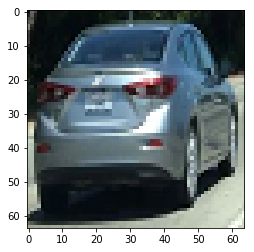

image name: ./expanded_vehicles\test8.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


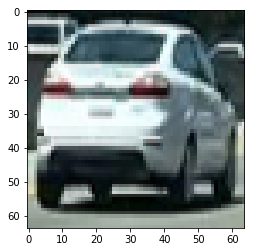

image name: ./expanded_vehicles\test8f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


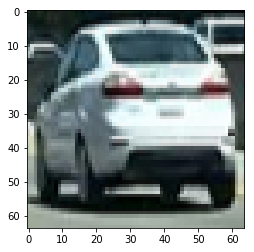

image name: ./expanded_vehicles\test9.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


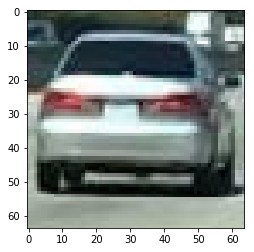

image name: ./expanded_vehicles\test9f.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


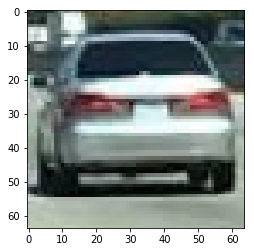

In [24]:
#Test on expanded vehicles data set
test_vehicles = glob.glob('./expanded_vehicles/*.png')
print(len(test_vehicles))

#for every image do the process the detection pipeline
for idx, fname in enumerate(test_vehicles):
    image = mpimg.imread(fname)
    test_img = np.copy(image[:,:,0:3])
    print("image name: {} shape: {}".format(fname, test_img.shape))


    #test_img = cv2.resize(test_img, (64, 64))      
    print(image.shape)

    #4) Extract features for that window using single_img_featuresYCrCb')
    features = single_img_features(test_img, color_space='YCrCb', 
                            spatial_size=(32, 32), hist_bins=32, 
                            orient=12, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)

    #5) Scale extracted features to be fed to classifier
    test_features = scaler.transform(np.array(features).reshape(1, -1))


    #6) Predict using your classifier
    prediction = clf.predict(test_features)
    print("prediction: ", prediction)
    plot_image (image)

15
image name: ./expanded-nonvehicles\non-car01.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


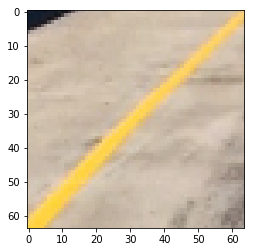

image name: ./expanded-nonvehicles\non-car02.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


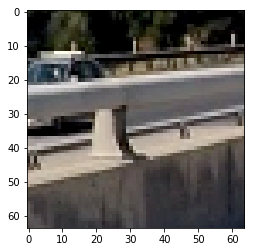

image name: ./expanded-nonvehicles\non-car03.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


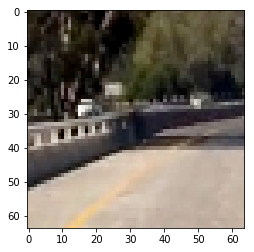

image name: ./expanded-nonvehicles\non-car04.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [1.]
(64, 64, 4)


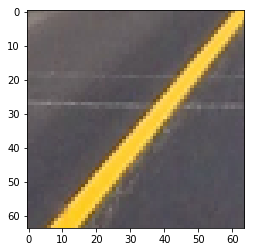

image name: ./expanded-nonvehicles\non-car04hf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


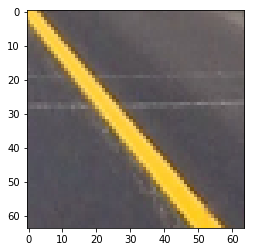

image name: ./expanded-nonvehicles\non-car05.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


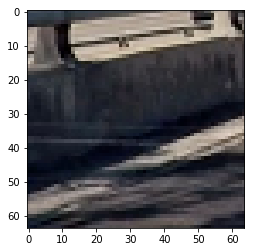

image name: ./expanded-nonvehicles\non-car05vf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


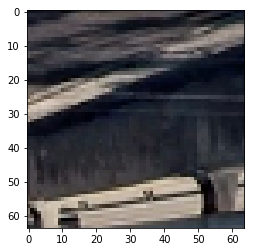

image name: ./expanded-nonvehicles\non-car06.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


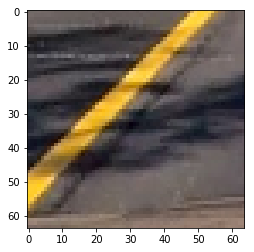

image name: ./expanded-nonvehicles\non-car06hf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


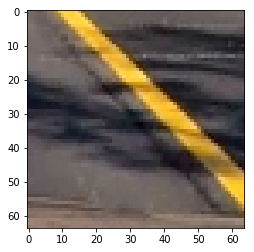

image name: ./expanded-nonvehicles\non-car07.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


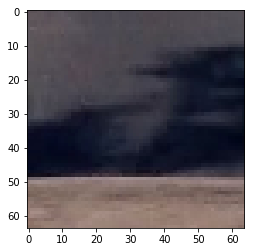

image name: ./expanded-nonvehicles\non-car07hf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


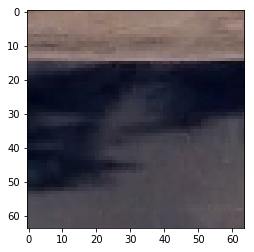

image name: ./expanded-nonvehicles\non-car07vf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


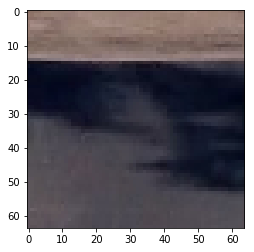

image name: ./expanded-nonvehicles\non-car08.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


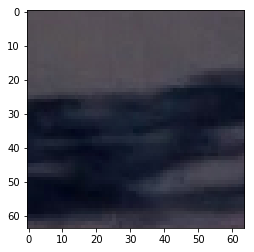

image name: ./expanded-nonvehicles\non-car08hf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


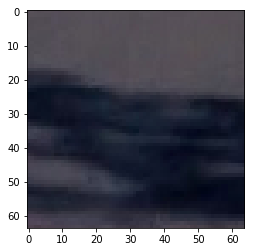

image name: ./expanded-nonvehicles\non-car08vf.png shape: (64, 64, 3)
(64, 64, 4)
prediction:  [0.]
(64, 64, 4)


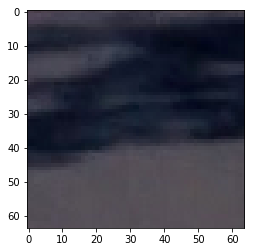

In [26]:
#Test on expanded vehicles data set
test_vehicles = glob.glob('./expanded-nonvehicles/*.png')
print(len(test_vehicles))

#for every image do the process the detection pipeline
for idx, fname in enumerate(test_vehicles):
    image = mpimg.imread(fname)
    test_img = np.copy(image[:,:,0:3])
    print("image name: {} shape: {}".format(fname, test_img.shape))


    #test_img = cv2.resize(test_img, (64, 64))      
    print(image.shape)

    #4) Extract features for that window using single_img_featuresYCrCb')
    features = single_img_features(test_img, color_space='YCrCb', 
                            spatial_size=(32, 32), hist_bins=32, 
                            orient=12, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)

    #5) Scale extracted features to be fed to classifier
    test_features = scaler.transform(np.array(features).reshape(1, -1))


    #6) Predict using your classifier
    prediction = clf.predict(test_features)
    print("prediction: ", prediction)
    plot_image (image)

In [ ]:


import matplotlib.pyplot as plt

y_start_stop = [400, (780-64)] # Min and max in y to search in slide_window()

# Make a list of test images
test_images = glob.glob('./test_images/*.jpg')

#for every image do the process the detection pipeline
for idx, fname in enumerate(test_images):
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    print("image name: {} shape: {}".format(fname, draw_image.shape))

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = draw_image.astype(np.float32)/255

    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=(sp_size, sp_size), hist_bins=h_bins, 
                        orient=n_orient, pix_per_cell=pp_cell, 
                        cell_per_block=cp_blk, 
                        hog_channel=hog_chn, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)                       
    print("hot windows: ", len(hot_windows))
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plot2imgs (image, fname, window_img, "Output")

## 3.  Finding Cars 
This section should be self contained.


In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size, hist_bins, color_space):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255   #done already in the preceding logic.
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #initialize car_boxes
    car_boxes_detected = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    

    #print(color_space)
    if scale != 1.:
        imshape = ctrans_tosearch.shape
        #print(imshape)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]    
        

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                #append the detected car to the box list; used with heatmap.
                car_boxes_detected.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, car_boxes_detected


In [ ]:
# Make a list of test images
test_images = glob.glob('./test_images/*.jpg')
ystart = 400
ystop = 656
scale = 1.0

#for every image do the process the detection pipeline
for idx, fname in enumerate(test_images):
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    print("image name: {} shape: {}".format(fname, draw_image.shape))

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = draw_image.astype(np.float32)/255

    out_img, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    print("{} boxes detected".format(len(boxes)))
    #print(boxes)
    plot2imgs (image, fname, out_img, "Output")

##  4. Heat Map
Adding Heat Map

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [ ]:

# Make a list of test images
test_images = glob.glob('./test_images/*.jpg')
ystart = 400
ystop = 600  #650
scale = 1.0

#for every image do the process the detection pipeline
for idx, fname in enumerate(test_images):
    image = mpimg.imread(fname)
    draw_image = np.copy(image)
    print("image name: {} shape: {}".format(fname, draw_image.shape))

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = draw_image.astype(np.float32)/255

    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    print("{} boxes detected".format(len(boxes)))
    #print(boxes)


    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plot_img_heat (draw_img, 'Car Positions', heatmap, "Heat Map")
    


## 7.  Video Processing
In this section implemented the class 'Line', based on the course material guidance and 'process_image()' function. I averging the Line fit polynomial coefficients over 5 most recent frames. I invoked incremental polynomial fitting, if most recent fit was fine within some sanity checks such as X-intercept distances. and co-efficient changes. Overall the processing pipeline worked reasonabl

In [ ]:
# Define a class to receive the characteristics of each line detection
class vehicles():
    def __init__(self):
        # was the line detected in the last iteration?
        self.last_boxes = []  

        
        #limit on the history
        self.history_limit = 9
        
        #most recent pixel count
        self.pixel_count = 0
        
    def update_fit(self, nex_boxes):
        self.last_boxes = new_boxes
        
 

In [ ]:
frames_missed = 0
intercept_dist = []
aggregate_frames = 0

In [ ]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region

def process_image(image):
    
    #initialize boxes
    car_boxes_detected = []
    threshold = 3
    
    draw_image = image.astype(np.float32)/255

    
    #set 1#########################
    ystart = 400
    ystop = 620
    scale = 1.0
    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    car_boxes_detected.extend(boxes)
    
    #set 2#########################
    ystart = 400
    ystop = 620
    scale = 1.25
    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    car_boxes_detected.extend(boxes)
    
    #set 3#########################
    ystart = 400
    ystop = 600
    scale = 1.5
    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    car_boxes_detected.extend(boxes)
 

    #set 3#########################
    ystart = 400
    ystop = 580
    scale = 1.75
    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    car_boxes_detected.extend(boxes)

    #set 4#########################
    ystart = 400
    ystop = 580
    scale = 2.0
    _, boxes = find_cars(draw_image, ystart, ystop, scale, clf, scaler, orient, pix_per_cell, cell_per_block, hog_channel,
              (spatial_size, spatial_size), hist_bins, color_space)
    car_boxes_detected.extend(boxes)
    
    #print("{} boxes detected".format(len(car_boxes_detected)))


    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,car_boxes_detected)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    out_img = draw_labeled_bboxes(np.copy(image), labels)


    return out_img

In [ ]:
    fname = "./test_images/test5.jpg"
    image = mpimg.imread(fname)
    print("image name: {} shape: {}".format(fname, draw_image.shape))
    out_img = process_image(image)

    plt.imshow(out_img)



In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_out = './project_output_video.mp4'
video_in = VideoFileClip('./project_video.mp4')
processed_video = video_in.fl_image(process_image)
%time processed_video.write_videofile(video_out, audio=False)